### To be run in colab

In [1]:
# mount the google drive folder
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

INFO     scvi-colab: Installing scvi-tools.                                                                        
INFO     scvi-colab: Install successful. Testing import.                                                           


In [3]:
!pip install --quiet git+https://github.com/theislab/scgen.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


### Import the metric -- scib

In [5]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!pip install --quiet scib
import scib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 2.6 MB/s eta 0:00:00


In [6]:
!pip install --quiet louvain
import louvain

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.2 MB/s eta 0:00:00


<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<ipython-input-6-bf0d4c071418>:2: DeprecationWarning: This package has been superseded by the `leidenalg` package and will no longer be

### Import the necessary library

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import time
import scvi
import anndata
import pandas as pd
from scipy.io import mmread
from scipy.sparse import csr_matrix
import umap
import matplotlib.pyplot as plt
import os
import tempfile
import seaborn as sns
import torch
import scgen
import scib
import louvain

In [2]:
import os
import tempfile

import gdown
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import scvi
import seaborn as sns
import torch
from scvi.external import CellAssign

In [3]:
import warnings

sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

# Suppress specific ImportWarning
warnings.filterwarnings("ignore", category=ImportWarning, message=".*AltairImportHook.find_spec() not found; falling back to find_module.*")

/opt/anaconda3/lib/python3.12/site-packages/scanpy/_settings.py:488: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/matplotlib_inline/config.py:54: DeprecationWarning: InlineBackend._print_figure_kwargs_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _update_figure_formatters(self):


### read the data

In [5]:
# adata = anndata.read_h5ad("/content/drive/MyDrive/scdata/Lung_atlas_public/Lung_atlas_public.h5ad")
adata = anndata.read_h5ad("./human_pancreas_norm.h5ad")
adata

/opt/anaconda3/lib/python3.12/site-packages/anndata/_io/specs/registry.py:256: OldFormatWarning: Element '/X' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=iospec)
/opt/anaconda3/lib/python3.12/site-packages/anndata/_io/specs/registry.py:256: OldFormatWarning: Element '/layers' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=iospec)
/opt/anaconda3/lib/python3.12/site-packages/anndata/_io/specs/registry.py:256: OldFormatWarning: Element '/layers/counts' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=iospec)
/opt/anaconda3/lib/python3.12/site-packages/anndata/_io/utils.py:207: OldFormatWarning: Element '/obs/__categories/tech' was written without encoding metadata.
  return func(*args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/anndata/_io/utils.py:207: OldFormatWarning: Element '/obs/tech' was written without encoding metadata.


AnnData object with n_obs × n_vars = 16382 × 19093
    obs: 'tech', 'celltype', 'size_factors'
    layers: 'counts'

In [6]:
celltype_markers = pd.read_csv("./celltype.csv", index_col=0)

adata.obs.index = adata.obs.index.astype("str")
adata.var.index = adata.var.index.astype("str")
adata.var_names_make_unique()
adata.obs_names_make_unique()

In [12]:
print(celltype_markers.index)

Index(['ACTA2', 'ARX', 'BANK1', 'CCL5', 'CD14', 'CD19', 'CD2', 'CD33', 'CD3D',
       'CD3E', 'CD3G', 'CD4', 'CD74', 'CD79A', 'CD79B', 'CD8A', 'CD8B', 'CDH1',
       'CDH5', 'CLEC14A', 'COL1A1', 'COL3A1', 'CXCR5', 'DCN', 'EMCN', 'EOMES',
       'EPCAM', 'FCGR3A', 'FOXL2', 'GZMA', 'ICA1', 'ICOS', 'IGKC', 'IGLC2',
       'IGLC3', 'IL7R', 'ITGAM', 'ITGAX', 'KRT8', 'LYZ', 'MCAM', 'MS4A1',
       'MUM1L1', 'MYH11', 'MYLK', 'NKG7', 'PDCD1', 'PECAM1', 'PLN', 'PTPRC',
       'RBP1', 'SERPINH1', 'ST8SIA1', 'TNFRSF4', 'TPT1', 'TRAC', 'VIM', 'VWF',
       'WFDC2'],
      dtype='object', name='Gene')


In [14]:
print(adata.var_names)

Index(['A1BG', 'A1CF', 'A2M', 'A2ML1', 'A4GALT', 'A4GNT', 'AA06', 'AAAS',
       'AACS', 'AACSP1',
       ...
       'ZW10', 'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11B', 'ZYX',
       'ZZEF1', 'ZZZ3'],
      dtype='object', length=19093)


In [16]:
adata = adata.copy()
adata.layers['counts'] = adata.X

In [17]:
# Ensure that only the shared gene names between adata.var_names and celltype_markers.index are kept.
bdata = adata[:, adata.var_names.isin(celltype_markers.index)].copy()

In [20]:
print(bdata.var_names)

Index(['ACTA2', 'ARX', 'BANK1', 'CCL5', 'CD14', 'CD19', 'CD2', 'CD33', 'CD3D',
       'CD3E', 'CD3G', 'CD4', 'CD74', 'CD79A', 'CD79B', 'CD8A', 'CD8B', 'CDH1',
       'CDH5', 'CLEC14A', 'COL1A1', 'COL3A1', 'CXCR5', 'DCN', 'EMCN', 'EOMES',
       'EPCAM', 'FCGR3A', 'FOXL2', 'GZMA', 'ICA1', 'ICOS', 'IGKC', 'IGLC2',
       'IGLC3', 'IL7R', 'ITGAM', 'ITGAX', 'KRT8', 'LYZ', 'MCAM', 'MS4A1',
       'MUM1L1', 'MYH11', 'MYLK', 'NKG7', 'PDCD1', 'PECAM1', 'PLN', 'PTPRC',
       'RBP1', 'SERPINH1', 'ST8SIA1', 'TNFRSF4', 'TPT1', 'TRAC', 'VIM', 'VWF',
       'WFDC2'],
      dtype='object')


## CellAssign

In [23]:
lib_size = adata.X.sum(1)
adata.obs["size_factors"] = lib_size / np.mean(lib_size)

A size factor may be defined manually as scaled library size (total UMI count) and should not be placed on the log scale, as the model will do this manually. The library size should be computed before any gene subsetting (in this case, technically, a few notebook cells up).

In [26]:
scvi.external.CellAssign.setup_anndata(bdata, size_factor_key="size_factors")

In [28]:
model = CellAssign(bdata, celltype_markers)
model.train()

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 20/400:   5%| | 19/400 [00:24<08:02,  1.27s/it, v_num=1, train_loss_step=5

/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [29]:
predictions = model.predict()
predictions.head()

,B cells (kappa),B cells (lambda),Cytotoxic T cells,CD4 T cells,Tfh,Monocyte/Macrophage,Epithelial cells,Ovarian stromal cells,Ovarian myofibroblast,Vascular smooth muscle cells,Endothelial cells,other
0,3.767817e-19,1.900077e-17,1.250888e-14,3.159652e-18,1.896292e-14,4.756949e-19,1.000000,2.771584e-07,1.846043e-14,2.515474e-19,6.392990e-19,3.210857e-16
1,1.410578e-06,1.929805e-06,8.515226e-05,3.002826e-06,2.443612e-07,2.079716e-14,0.998377,9.508599e-06,1.493419e-03,2.726402e-09,9.105170e-09,2.783641e-05
2,4.332662e-15,1.045797e-14,2.449719e-15,1.378392e-15,6.546475e-13,4.023196e-11,0.985667,1.433255e-02,1.257747e-09,1.489158e-12,4.126336e-12,3.217385e-13
3,1.473535e-13,3.275886e-13,2.132858e-11,3.670017e-14,5.558681e-14,1.901498e-10,0.982070,1.793016e-02,9.009365e-11,1.178437e-15,3.515684e-15,1.777479e-11
4,2.508351e-09,5.943863e-09,2.033184e-05,7.719075e-10,1.073744e-09,1.853763e-09,0.000627,9.921236e-01,7.223119e-03,6.211412e-06,1.032949e-10,1.913496e-07


/opt/anaconda3/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/anaconda3/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


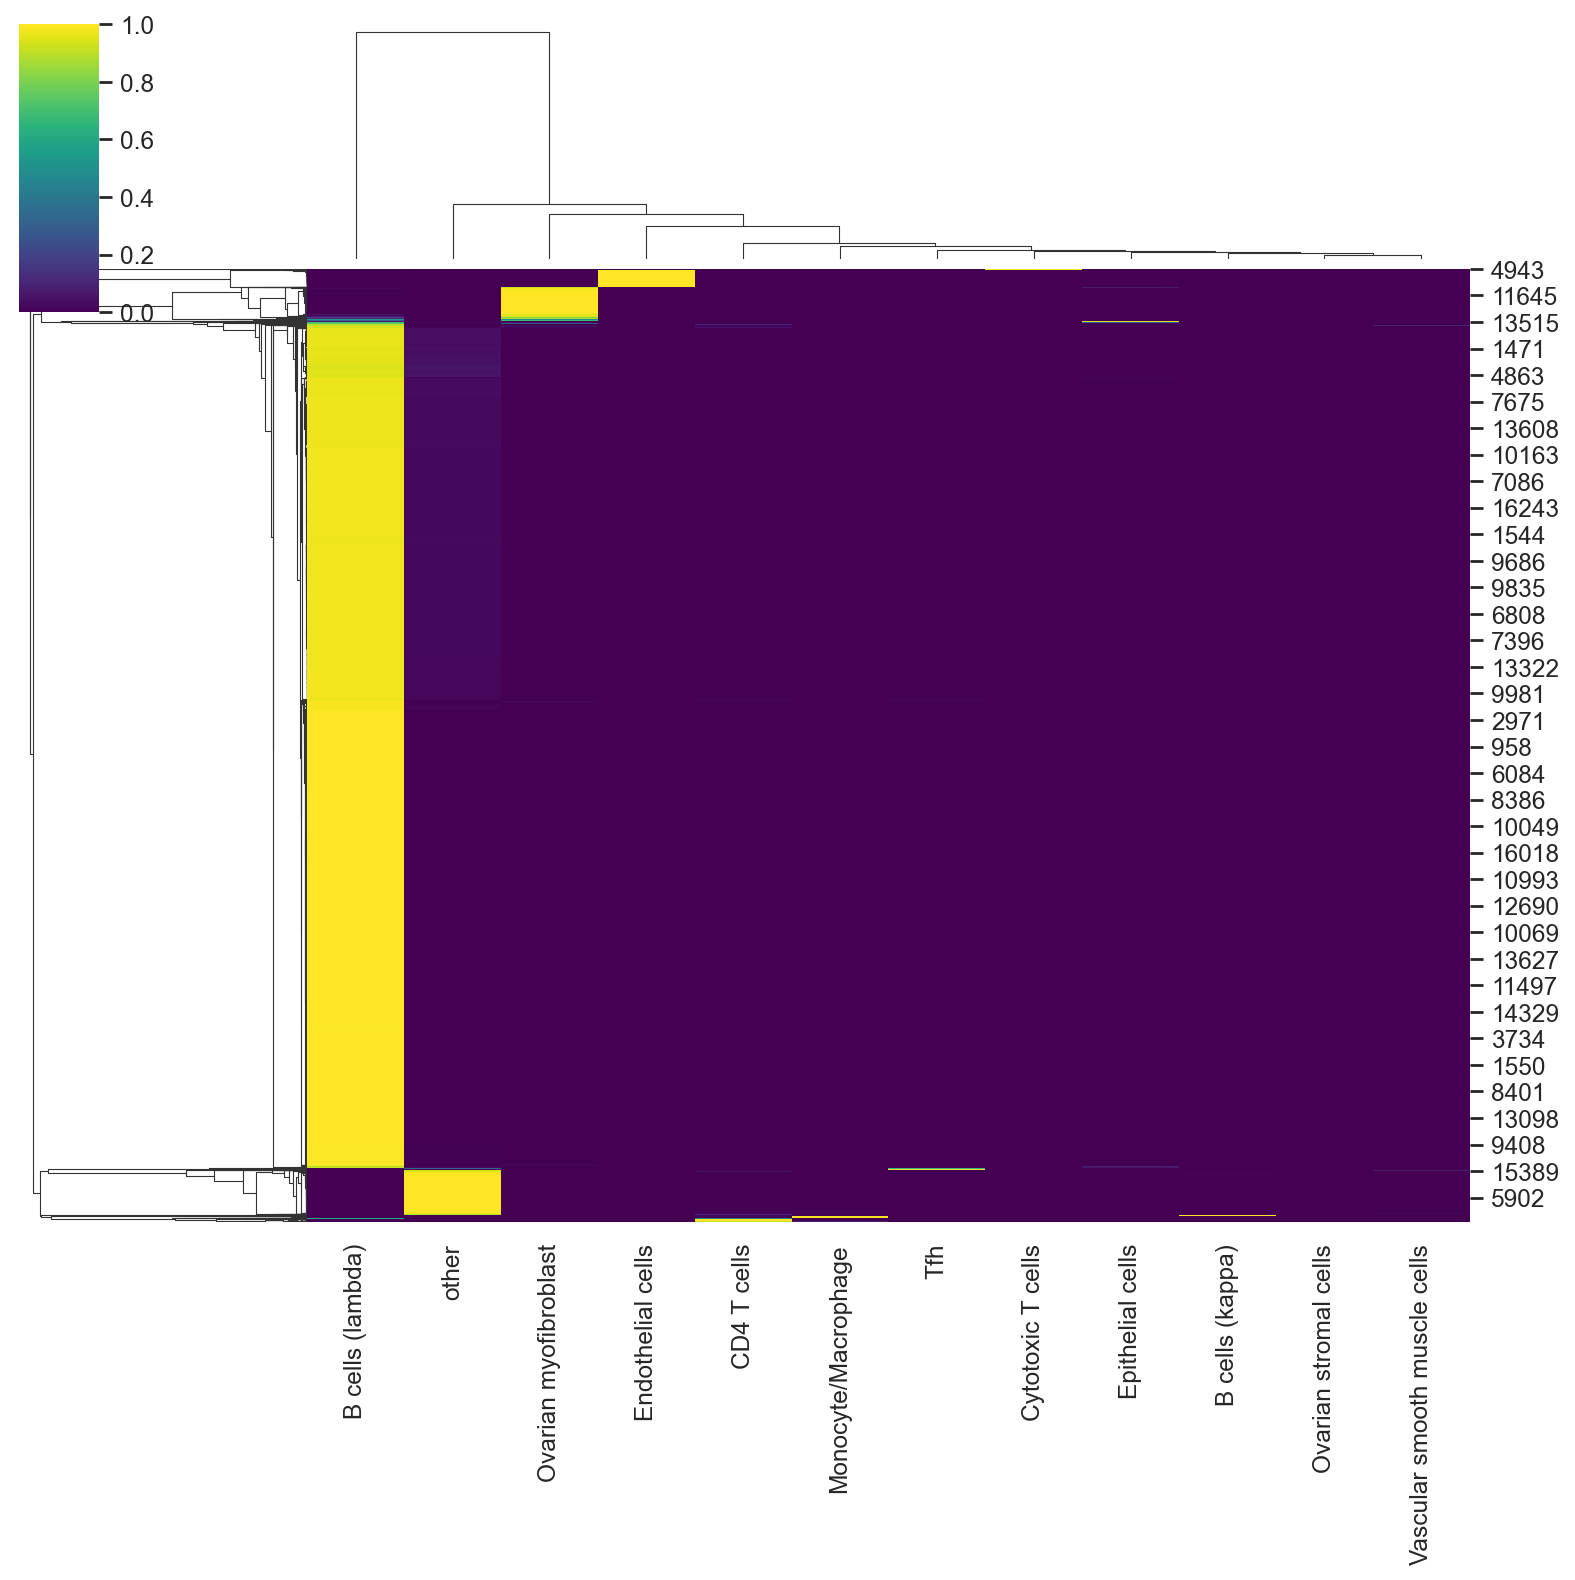

In [46]:
sns.clustermap(predictions, cmap="viridis")

In [47]:
bdata.obs["cellassign_predictions"] = predictions.idxmax(axis=1).values

In [48]:
# save the prediction results to csv file
import pandas as pd

cellassign_predictions = bdata.obs["cellassign_predictions"]

cellassign_predictions.to_csv("./human_pancreas_cellassign_predictions.csv", index=True)

In [34]:
predictions = pd.read_csv("./human_pancreas_cellassign_predictions.csv")
adata.obs['predict_labels'] = predictions['cellassign_predictions'].values

In [36]:
# preprocessing
adata.raw = adata
adata.layers["counts"] = adata.X.copy()
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key='tech')
adata = adata[:, adata.var['highly_variable']]

In [37]:
# Initialize the dictionary to store embeddings
embeddings_dict = {}

# scANVI

In [14]:
# scVI
adata = adata.copy()
adata.layers['counts'] = adata.X
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=50, gene_likelihood="nb")
vae.train()
adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.5)

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen impo

Epoch 273/273: 100%|██████████| 273/273 [08:26<00:00,  1.85s/it, v_num=1, train_loss_step=745, train_loss_epoch=766]

INFO: `Trainer.fit` stopped: `max_epochs=273` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=273` reached.


Epoch 273/273: 100%|██████████| 273/273 [08:26<00:00,  1.85s/it, v_num=1, train_loss_step=745, train_loss_epoch=766]


<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen impo

scANVI should be initialized from a scVI model pre-trained on the same exact data.

In [43]:
import scvi

# Set up the AnnData object
adata = adata.copy()
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="tech")

# Load the trained model
model_path = "./model_scVI"
vae = scvi.model.SCVI.load(model_path, adata=adata)

# Now you can use the loaded model for further analysis or inference
adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.5)

INFO     File ./model_scVI/model.pt already downloaded                                                             


/opt/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/opt/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [45]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata,
    labels_key="predict_labels",
    unlabeled_category="Unknown",
)

/opt/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [47]:
scanvi_model.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                                                   


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 20/20: 100%|█| 20/20 [00:55<00:00,  2.88s/it, v_num=1, train_loss_step=1.3

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|█| 20/20 [00:55<00:00,  2.77s/it, v_num=1, train_loss_step=1.3


In [48]:
SCANVI_LATENT_KEY = "X_scANVI"
SCANVI_PREDICTIONS_KEY = "C_scANVI"

adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(adata)
adata.obs[SCANVI_PREDICTIONS_KEY] = scanvi_model.predict(adata)

In [49]:
# Save the embeddings
# Collect scANVI embeddings and predictions in the dictionary
embeddings_dict['X_scANVI'] = adata.obsm[SCANVI_LATENT_KEY]
embeddings_dict[SCANVI_PREDICTIONS_KEY] = adata.obs[SCANVI_PREDICTIONS_KEY]

In [50]:
sc.pp.neighbors(adata, use_rep=SCANVI_LATENT_KEY)
sc.tl.umap(adata)

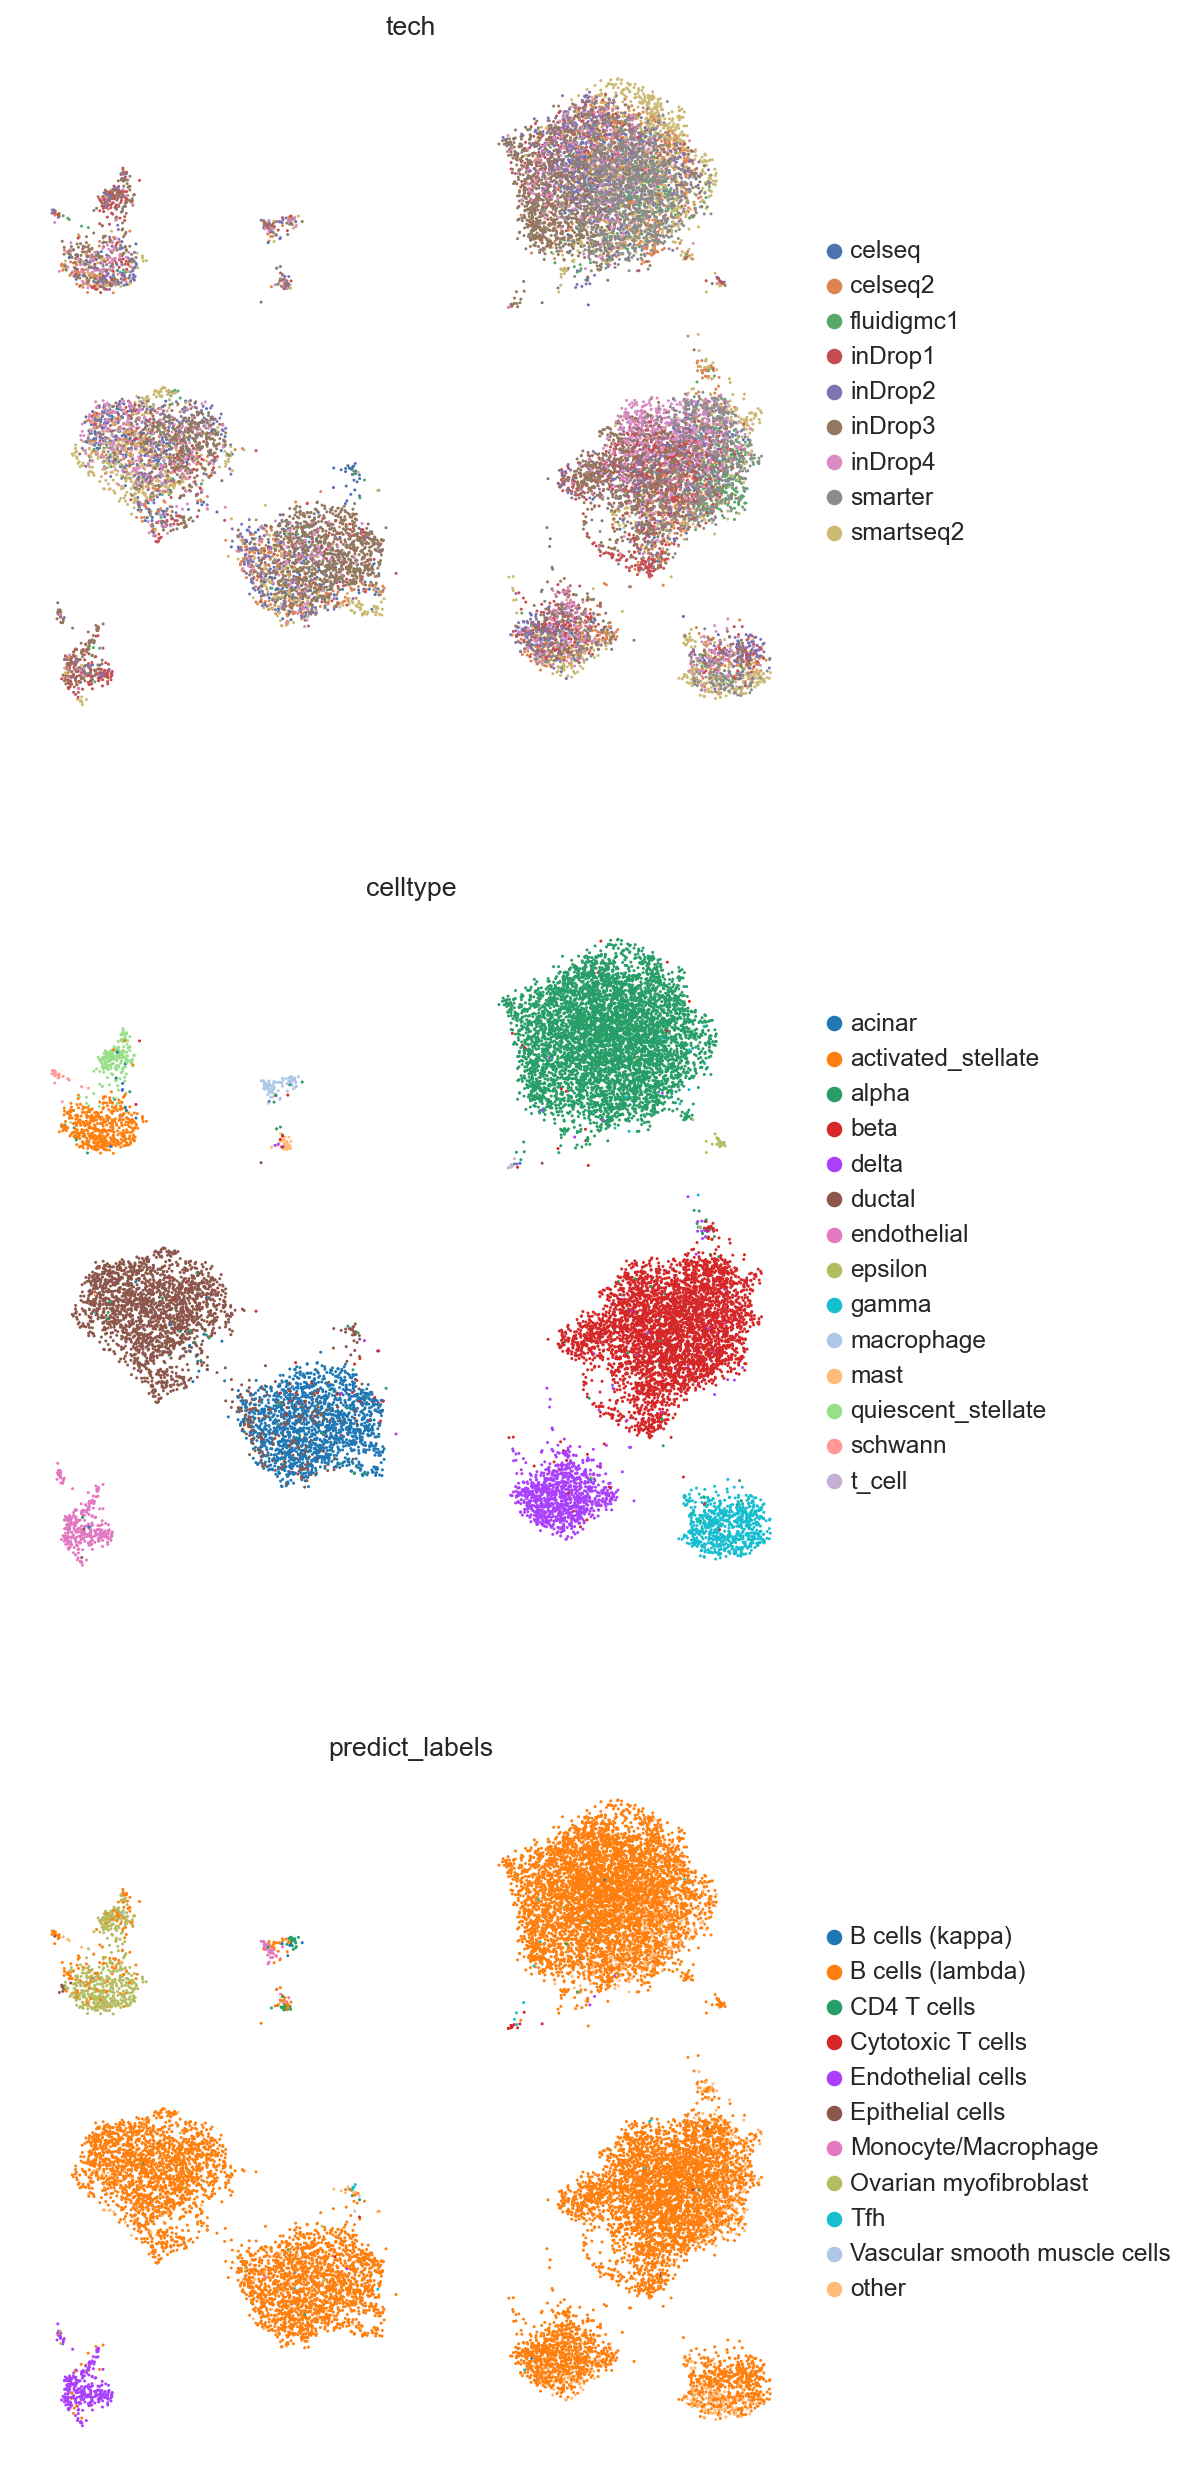

In [60]:
sc.pl.umap(adata, color=["tech", "celltype", "predict_labels"], frameon=False, ncols=1)

# scGEN

We need two observation labels "batch" and "cell_type" for our batch_removal procedure. There exist a "batch" obs but no "cell_type", so we add it as a .obs of adata (but we have cell_type in this datasets)

In [62]:
train = adata.copy()

### Preprocessing Data

In [64]:
scgen.SCGEN.setup_anndata(train, batch_key="tech", labels_key="predict_labels")

## Creating and Training the model¶

In [67]:
model = scgen.SCGEN(train)

model.train(
    max_epochs=100,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=25,
)
# model.save("../saved_models/model_batch_removal.pt", overwrite=True)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 27/100:  27%|▎| 27/100 [03:17<08:52,  7.30s/it, v_num=1, train_loss_step=1
Monitored metric elbo_validation did not improve in the last 25 records. Best score: 1014.586. Signaling Trainer to stop.


## Batch-Removal

In [69]:
corrected_adata = model.batch_removal()
corrected_adata

/opt/anaconda3/lib/python3.12/site-packages/scgen/_scgen.py:268: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  all_shared_ann = AnnData.concatenate(


INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


AnnData object with n_obs × n_vars = 16382 × 2000
    obs: 'tech', 'celltype', 'size_factors', 'predict_labels', 'n_genes', 'n_counts', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'latent', 'corrected_latent'

In [70]:
# Save embeddings
corrected_adata.obsm["X_scgen"] = corrected_adata.obsm["latent"]

# Collect embeddings
embeddings_dict["X_scgen"] = corrected_adata.obsm["X_scgen"]

### Visualization of the corrected gene expression data¶

In [72]:
sc.pp.neighbors(corrected_adata)
sc.tl.umap(corrected_adata)

/opt/anaconda3/lib/python3.12/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 2000 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


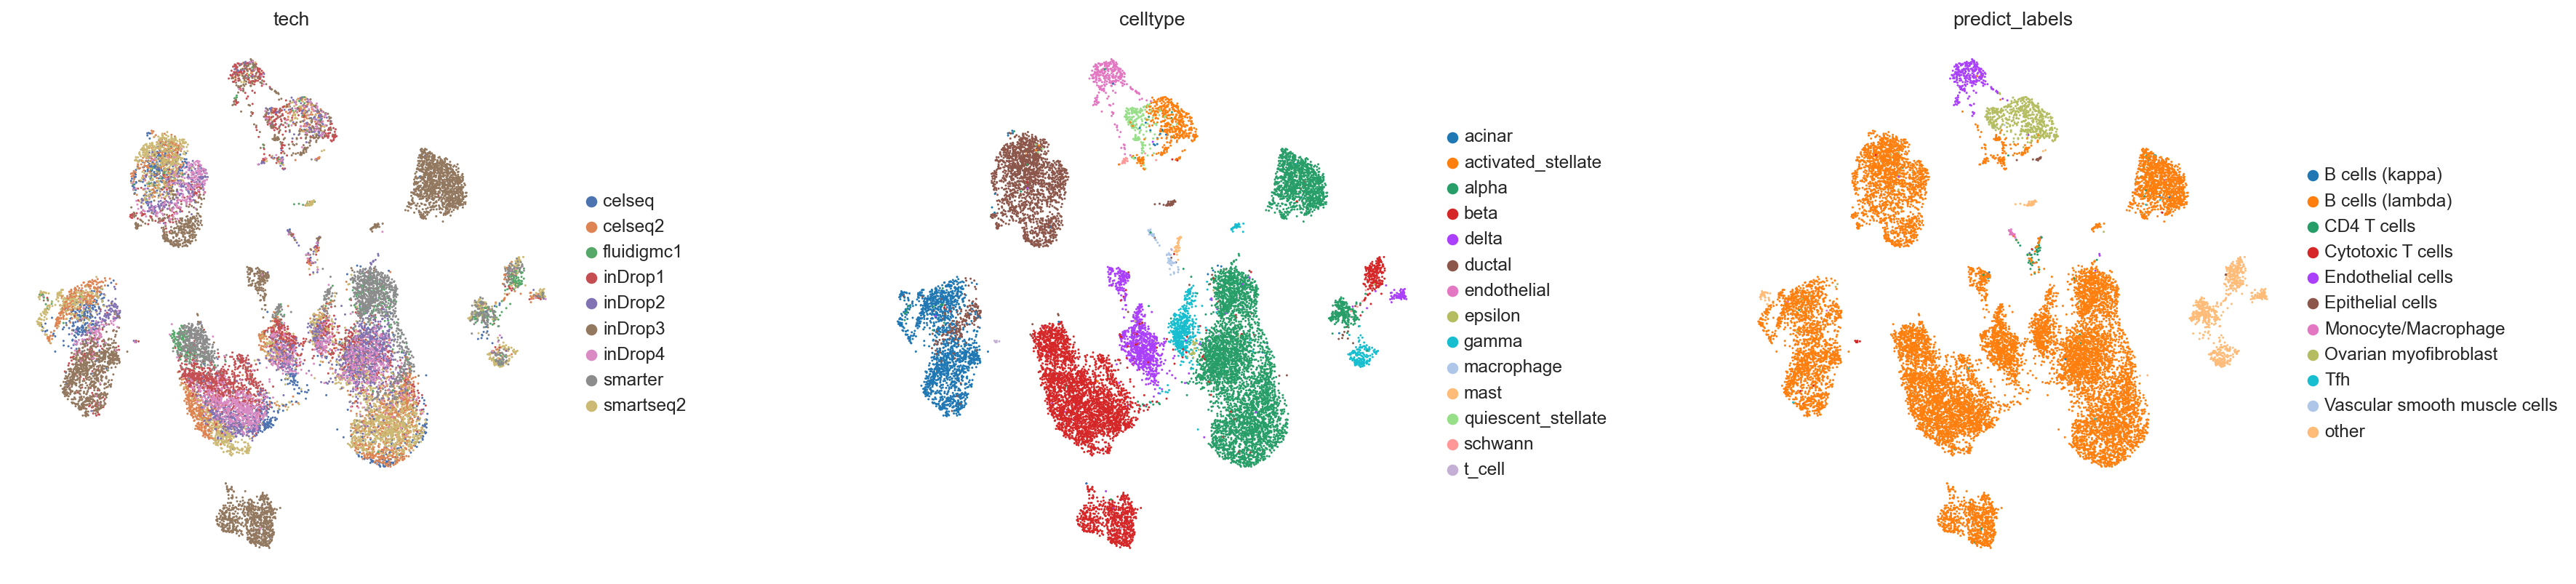

In [73]:
sc.pl.umap(corrected_adata, color=['tech', 'celltype', 'predict_labels'], wspace=0.4, frameon=False)

# STACAS

Semi-supervised integration results

In [77]:
pca_embeddings = pd.read_csv('./human_pancreas_stacas_embeddings_cell_assign.csv', index_col=0)
adata.obsm['X_stacas'] = pca_embeddings.values
sc.pp.neighbors(adata, use_rep="X_stacas")
sc.tl.umap(adata, min_dist=0.5)

In [78]:
# Collect embeddings
embeddings_dict["X_stacas"] = adata.obsm['X_stacas']

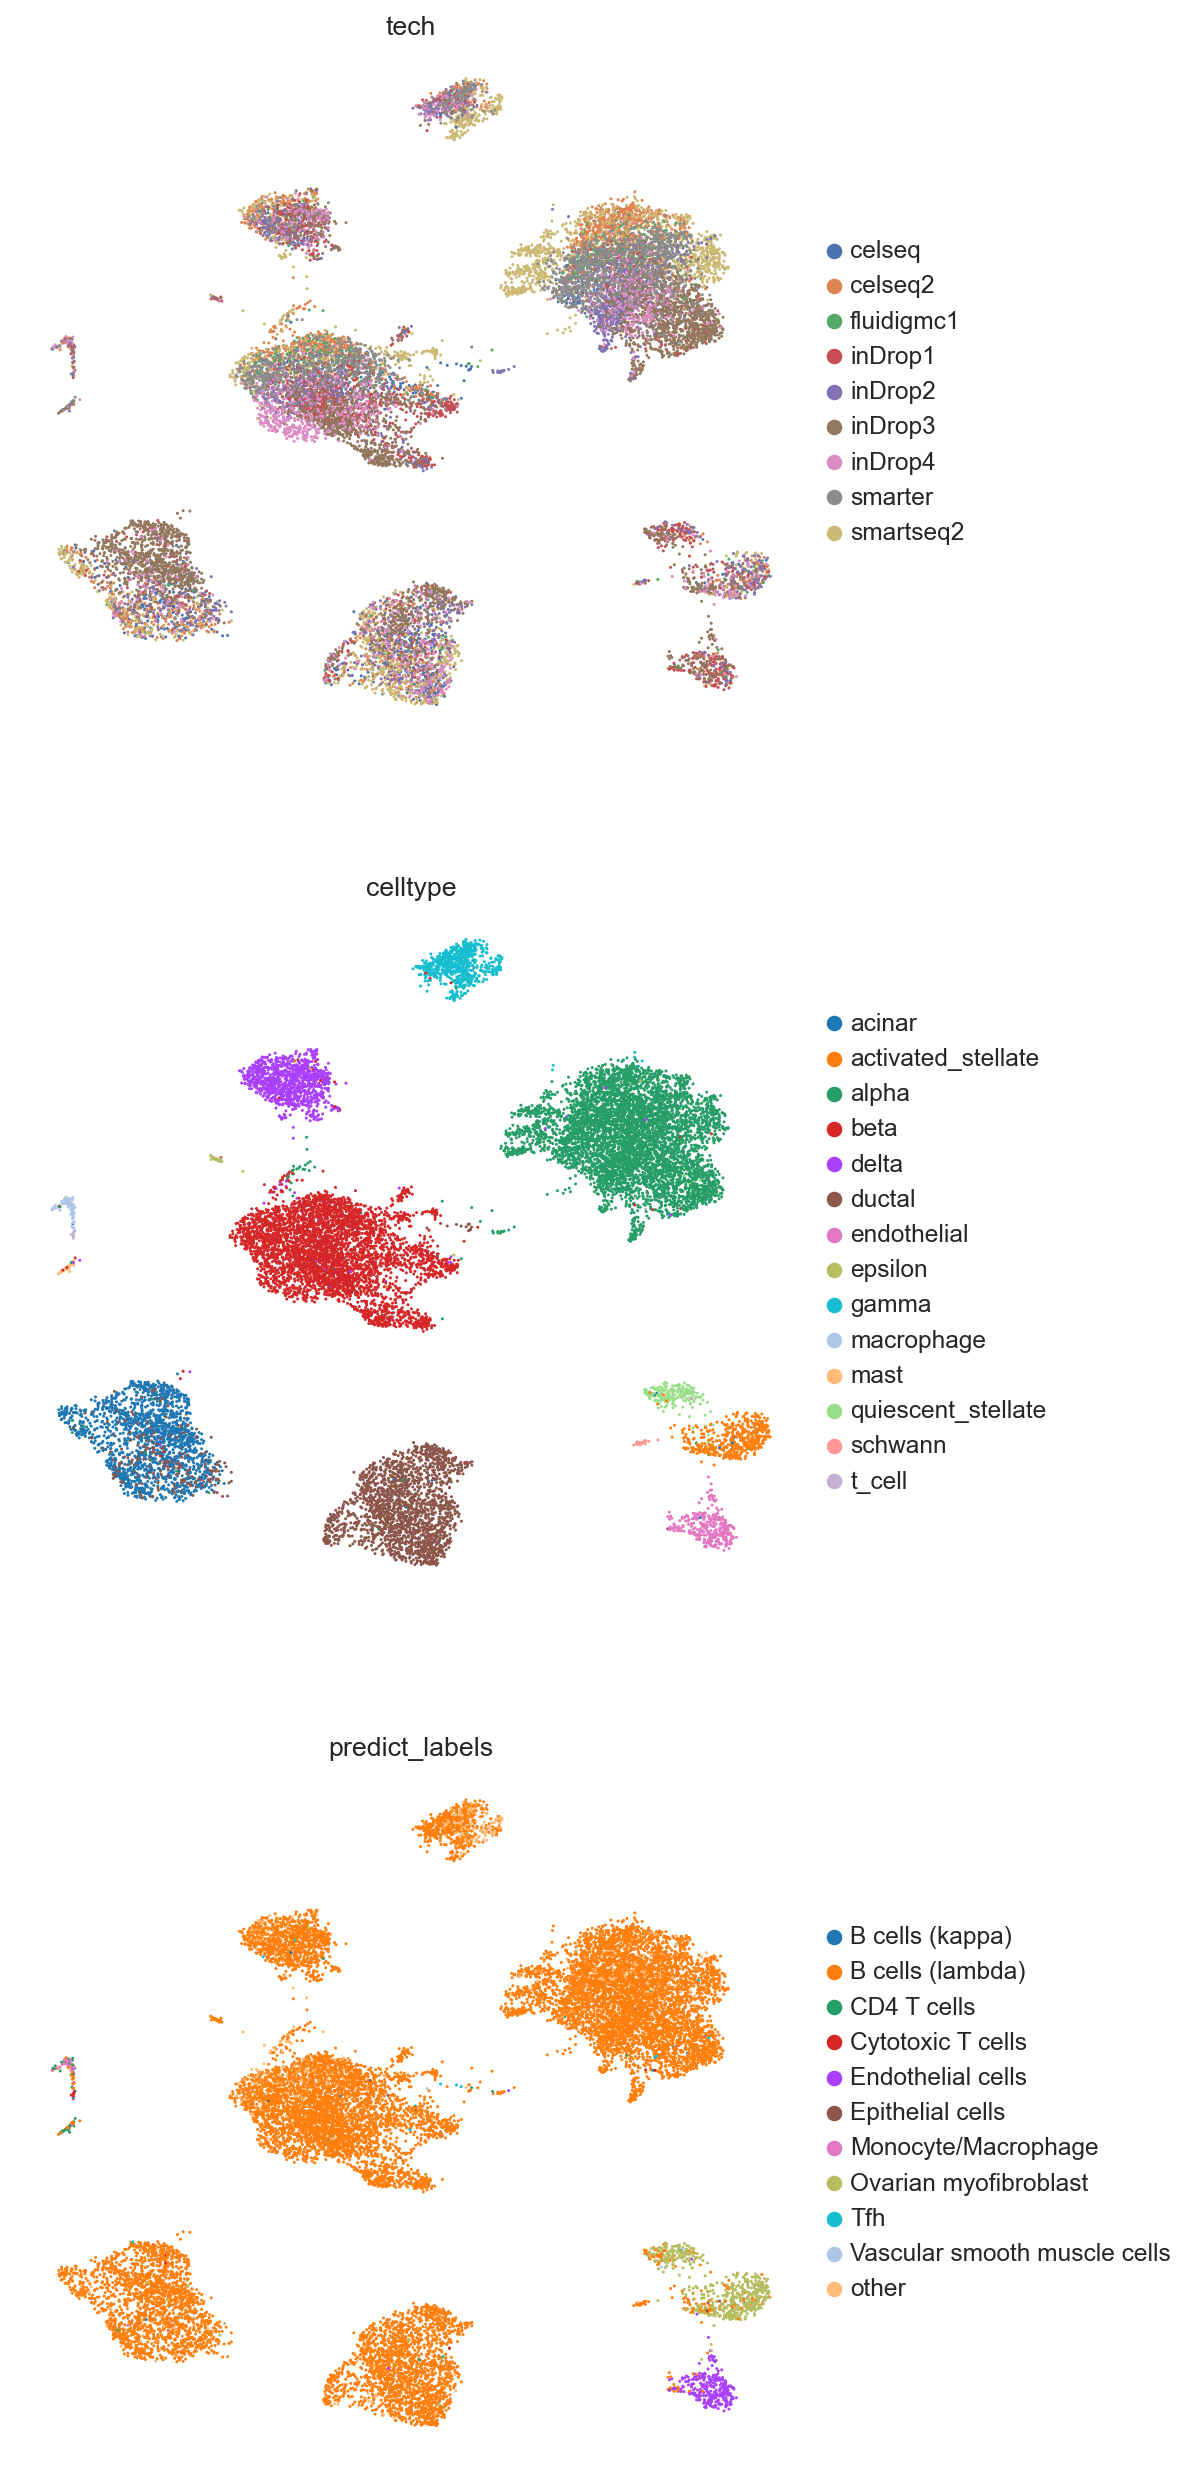

In [85]:
sc.pl.umap(adata, color=["tech", "celltype", "predict_labels"], frameon=False, ncols=1)

In [87]:
# save all the embeddings
# Concatenate embeddings and save to CSV
combined_embeddings = pd.concat(
    {key: pd.DataFrame(value, index=adata.obs_names) for key, value in embeddings_dict.items()},
    axis=1
)
combined_embeddings.to_csv("./cell_assign_human_pancreas.csv")


# Metric Evaluations

In [91]:
# Step 1: Read the CSV file into a DataFrame
combined_embeddings = pd.read_csv("./cell_assign_human_pancreas.csv", index_col=0)

# Step 2: Ensure indices match
combined_embeddings = combined_embeddings.loc[adata.obs_names]

# Step 3: Split the DataFrame into separate DataFrames for each embedding
embedding_keys = ["X_scANVI", "X_scgen", "X_stacas"]
embeddings_dict = {key: combined_embeddings.filter(like=key) for key in embedding_keys}

# Step 4: Assign the embeddings back to adata.obsm
for key, df in embeddings_dict.items():
    adata.obsm[key] = df.values

# Now `adata.obsm` contains the loaded embeddings

In [93]:
sc.pp.neighbors(adata, use_rep="X_scANVI")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="celltype")
df1_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, isolated_labels_asw_=True,  batch_key='tech', label_key = 'celltype', embed = 'X_scANVI')

/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/clustering.py:101: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  cluster_function(adata, resolution=res, key_added=cluster_key, **kwargs)


resolution: 0.1, nmi: 0.9056087210650928
resolution: 0.2, nmi: 0.9059741388312181
resolution: 0.3, nmi: 0.9079322477494802
resolution: 0.4, nmi: 0.9058933152883525
resolution: 0.5, nmi: 0.9064053425625976
resolution: 0.6, nmi: 0.9059090299903274
resolution: 0.7, nmi: 0.8886760616664778
resolution: 0.8, nmi: 0.8595407086704192
resolution: 0.9, nmi: 0.8234997094247106
resolution: 1.0, nmi: 0.801868630811025
resolution: 1.1, nmi: 0.7763124783549963
resolution: 1.2, nmi: 0.7638444705609126
resolution: 1.3, nmi: 0.7687445413933138
resolution: 1.4, nmi: 0.734934457145899
resolution: 1.5, nmi: 0.7351661410033895
resolution: 1.6, nmi: 0.7142490811838057
resolution: 1.7, nmi: 0.7071388951109722
resolution: 1.8, nmi: 0.6791932710153826
resolution: 1.9, nmi: 0.6779818452119465
resolution: 2.0, nmi: 0.6626090919502604
optimised clustering against celltype
optimal cluster resolution: 0.3
optimal score: 0.9079322477494802


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Isolated labels F1...


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


Compute neighbors on rep X_scANVI
Isolated labels ASW...


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


Graph connectivity...


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/ana

In [94]:
sc.pp.neighbors(adata, use_rep="X_scgen")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="celltype")
df2_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, isolated_labels_asw_=True,  batch_key='tech', label_key = 'celltype', embed = 'X_scgen')

resolution: 0.1, nmi: 0.8397881864284865
resolution: 0.2, nmi: 0.7930946179490349
resolution: 0.3, nmi: 0.7720060903424847
resolution: 0.4, nmi: 0.7151437298238132
resolution: 0.5, nmi: 0.715852898406447
resolution: 0.6, nmi: 0.7145910467932374
resolution: 0.7, nmi: 0.7140468761357582
resolution: 0.8, nmi: 0.7113349676622022
resolution: 0.9, nmi: 0.7001074325935951
resolution: 1.0, nmi: 0.7003606855307797
resolution: 1.1, nmi: 0.699803615569712
resolution: 1.2, nmi: 0.6930096081590285
resolution: 1.3, nmi: 0.6941478604209144
resolution: 1.4, nmi: 0.6810334164366638
resolution: 1.5, nmi: 0.6765309439511917
resolution: 1.6, nmi: 0.6763999705059576
resolution: 1.7, nmi: 0.6691629582241992
resolution: 1.8, nmi: 0.6655482562625543
resolution: 1.9, nmi: 0.6498620819126647
resolution: 2.0, nmi: 0.6324989924930338
optimised clustering against celltype
optimal cluster resolution: 0.1
optimal score: 0.8397881864284865


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Isolated labels F1...


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


Compute neighbors on rep X_scgen
Isolated labels ASW...


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


Graph connectivity...


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/ana

In [95]:
sc.pp.neighbors(adata, use_rep="X_stacas")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="celltype")
df3_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, isolated_labels_asw_=True,  batch_key='tech', label_key = 'celltype', embed = 'X_scANVI')

resolution: 0.1, nmi: 0.9224151829913418
resolution: 0.2, nmi: 0.9288426040509137
resolution: 0.3, nmi: 0.9241581592281901
resolution: 0.4, nmi: 0.8714511155488394
resolution: 0.5, nmi: 0.8444144309853738
resolution: 0.6, nmi: 0.8395188172784126
resolution: 0.7, nmi: 0.837105655336283
resolution: 0.8, nmi: 0.8043941598054599
resolution: 0.9, nmi: 0.7879988999369759
resolution: 1.0, nmi: 0.786462295924198
resolution: 1.1, nmi: 0.7601879489558344
resolution: 1.2, nmi: 0.7370290736745663
resolution: 1.3, nmi: 0.7207996936527966
resolution: 1.4, nmi: 0.706082730740996
resolution: 1.5, nmi: 0.714522023401156
resolution: 1.6, nmi: 0.6977047180436231
resolution: 1.7, nmi: 0.6960789352783638
resolution: 1.8, nmi: 0.6907649938064278
resolution: 1.9, nmi: 0.6810553867168936
resolution: 2.0, nmi: 0.6805463539450087
optimised clustering against celltype
optimal cluster resolution: 0.2
optimal score: 0.9288426040509137


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Isolated labels F1...


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


Compute neighbors on rep X_scANVI
Isolated labels ASW...


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


Graph connectivity...


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/ana

In [96]:
# Adding new columns to each dataframe
df1_1['scANVI'] = df1_1.iloc[:, 0]
df2_1['scGEN'] = df2_1.iloc[:, 0]
df3_1['STACAS'] = df3_1.iloc[:, 0]

# Selecting only the new columns to avoid duplicate data
df1_1 = df1_1[['scANVI']]
df2_1 = df2_1[['scGEN']]
df3_1 = df3_1[['STACAS']]

# Merging the dataframes along the columns
merged_df = pd.concat([df1_1, df2_1, df3_1], axis=1)

merged_df

,scANVI,scGEN,STACAS
NMI_cluster/label,0.907862,0.817687,0.926058
ARI_cluster/label,0.941904,0.873897,0.955608
ASW_label,0.559812,0.563750,0.559812
ASW_label/batch,0.878671,0.855251,0.878671
PCR_batch,NaN,NaN,NaN
cell_cycle_conservation,NaN,NaN,NaN
isolated_label_F1,0.150538,0.163934,0.150538
isolated_label_silhouette,0.719847,0.654349,0.719847
graph_conn,0.987227,0.963325,0.984016
kBET,NaN,NaN,NaN


## read the embeddings

In [ ]:
# Step 1: Read the CSV file into a DataFrame
combined_embeddings = pd.read_csv("/content/drive/MyDrive/scdata/Lung_atlas_public/partially_annotated_batches_lung_atlas.csv", index_col=0)

# Step 2: Ensure indices match
combined_embeddings = combined_embeddings.loc[adata.obs_names]

# Step 3: Split the DataFrame into separate DataFrames for each embedding
embedding_keys = ["X_scANVI", "X_scgen", "X_stacas"]
embeddings_dict = {key: combined_embeddings.filter(like=key) for key in embedding_keys}

# Step 4: Assign the embeddings back to adata.obsm
for key, df in embeddings_dict.items():
    adata.obsm[key] = df.values

# Now `adata.obsm` contains the loaded embeddings

## Bio-conservation

In [35]:
sc.pp.neighbors(adata, use_rep="X_scANVI")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df1_1 = scib.me.metrics(adata, adata_int=adata, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, clisi_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_scANVI')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/scib/metrics/clustering.py:101: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  cluster_function(adata, resolution=res, key_added=cluster_key, **kwargs)


resolution: 0.1, nmi: 0.7509168792862451
resolution: 0.2, nmi: 0.7727790202623026
resolution: 0.3, nmi: 0.7729375325389851
resolution: 0.4, nmi: 0.7762698630001107
resolution: 0.5, nmi: 0.7780598898818485
resolution: 0.6, nmi: 0.7748712760161829
resolution: 0.7, nmi: 0.7784023104998072
resolution: 0.8, nmi: 0.7692636547682328
resolution: 0.9, nmi: 0.7682961661951018
resolution: 1.0, nmi: 0.7658771670771896
resolution: 1.1, nmi: 0.7578705316195885
resolution: 1.2, nmi: 0.7456842062128652
resolution: 1.3, nmi: 0.7421518204080233
resolution: 1.4, nmi: 0.7373025793728257
resolution: 1.5, nmi: 0.7233522265377774
resolution: 1.6, nmi: 0.7163099357513387
resolution: 1.7, nmi: 0.7124808314733442
resolution: 1.8, nmi: 0.7156559279579839
resolution: 1.9, nmi: 0.7010527849428863
resolution: 2.0, nmi: 0.6885827692713679
optimised clustering against cell_type
optimal cluster resolution: 0.7
optimal score: 0.7784023104998072


/usr/local/lib/python3.10/dist-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Isolated labels F1...


<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
/usr/local/lib/python3.10/dist-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated

Compute neighbors on rep X_scANVI
Isolated labels ASW...
cLISI score...


/usr/local/lib/python3.10/dist-packages/scib/metrics/lisi.py:175: UserWarning: 'batch_key' is deprecated and will be ignore
  warnings.warn("'batch_key' is deprecated and will be ignore", stacklevel=1)


In [36]:
sc.pp.neighbors(adata, use_rep="X_scgen")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df2_1 = scib.me.metrics(adata, adata_int=adata, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, clisi_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_scgen')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


resolution: 0.1, nmi: 0.6742661365894647
resolution: 0.2, nmi: 0.6963206696715144
resolution: 0.3, nmi: 0.7114024170168652
resolution: 0.4, nmi: 0.7125777206070899
resolution: 0.5, nmi: 0.7080862939882288
resolution: 0.6, nmi: 0.7013718806304386
resolution: 0.7, nmi: 0.7015085632619965
resolution: 0.8, nmi: 0.7042202042595745
resolution: 0.9, nmi: 0.7052215603403496
resolution: 1.0, nmi: 0.7012388984127955
resolution: 1.1, nmi: 0.6999816185889118
resolution: 1.2, nmi: 0.6957352848796149
resolution: 1.3, nmi: 0.6914993469962752
resolution: 1.4, nmi: 0.6905809025772667
resolution: 1.5, nmi: 0.6897129846016505
resolution: 1.6, nmi: 0.6924620050027335
resolution: 1.7, nmi: 0.6904916695587792
resolution: 1.8, nmi: 0.6863978049430421
resolution: 1.9, nmi: 0.6843719934903281
resolution: 2.0, nmi: 0.6886036986635266
optimised clustering against cell_type
optimal cluster resolution: 0.4
optimal score: 0.7125777206070899


/usr/local/lib/python3.10/dist-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Isolated labels F1...


/usr/local/lib/python3.10/dist-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


Compute neighbors on rep X_scgen
Isolated labels ASW...
cLISI score...


/usr/local/lib/python3.10/dist-packages/scib/metrics/lisi.py:175: UserWarning: 'batch_key' is deprecated and will be ignore
  warnings.warn("'batch_key' is deprecated and will be ignore", stacklevel=1)


In [ ]:
sc.pp.neighbors(adata, use_rep="X_stacas")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df3_1 = scib.me.metrics(adata, adata_int=adata, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, clisi_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_stacas')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


resolution: 0.1, nmi: 0.7016617028562566
resolution: 0.2, nmi: 0.7421402867307022
resolution: 0.3, nmi: 0.7346143749529676
resolution: 0.4, nmi: 0.743249159994255
resolution: 0.5, nmi: 0.7246839001085923
resolution: 0.6, nmi: 0.7299032930615165
resolution: 0.7, nmi: 0.7166517950267433
resolution: 0.8, nmi: 0.7153770766607105
resolution: 0.9, nmi: 0.7097716868383548
resolution: 1.0, nmi: 0.700587128711058
resolution: 1.1, nmi: 0.6994288693174288
resolution: 1.2, nmi: 0.6985166352336649
resolution: 1.3, nmi: 0.6743249399583492
resolution: 1.4, nmi: 0.6724326237268916
resolution: 1.5, nmi: 0.673835098631305
resolution: 1.6, nmi: 0.6660282406534599
resolution: 1.7, nmi: 0.6624044466896645
resolution: 1.8, nmi: 0.6556916325596742
resolution: 1.9, nmi: 0.662501286641361
resolution: 2.0, nmi: 0.6587037370099991
optimised clustering against cell_type
optimal cluster resolution: 0.4
optimal score: 0.743249159994255


/usr/local/lib/python3.10/dist-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Isolated labels F1...


/usr/local/lib/python3.10/dist-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


Compute neighbors on rep X_stacas
Isolated labels ASW...
cLISI score...


/usr/local/lib/python3.10/dist-packages/scib/metrics/lisi.py:175: UserWarning: 'batch_key' is deprecated and will be ignore
  warnings.warn("'batch_key' is deprecated and will be ignore", stacklevel=1)


In [ ]:
# Adding new columns to each dataframe
df1_1['scANVI'] = df1_1.iloc[:, 0]
df2_1['scGEN'] = df2_1.iloc[:, 0]
df3_1['STACAS'] = df3_1.iloc[:, 0]

# Selecting only the new columns to avoid duplicate data
df1_1 = df1_1[['scANVI']]
df2_1 = df2_1[['scGEN']]
df3_1 = df3_1[['STACAS']]

# Merging the dataframes along the columns
merged_df_cell = pd.concat([df1_1, df2_1, df3_1], axis=1)

merged_df_cell

## Batch Effect Removal

### continue with the calculation

In [ ]:
df1_2 = scib.me.metrics(adata, adata, silhouette_=True, ilisi_=True, graph_conn_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_scANVI')

In [ ]:
df2_2 = scib.me.metrics(adata, adata, silhouette_=True, ilisi_=True, graph_conn_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_scgen')

In [ ]:
df3_2 = scib.me.metrics(adata, adata, silhouette_=True, ilisi_=True, graph_conn_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_stacas')

In [ ]:
# Adding new columns to each dataframe
df1_2['scANVI'] = df1_2.iloc[:, 0]
df2_2['scGEN'] = df2_2.iloc[:, 0]
df3_2['STACAS'] = df3_2.iloc[:, 0]

# Selecting only the new columns to avoid duplicate data
df1_2 = df1_2[['scANVI']]
df2_2 = df2_2[['scGEN']]
df3_2 = df3_2[['STACAS']]

# Merging the dataframes along the columns
merged_df_batch = pd.concat([df1_2, df2_2, df3_2], axis=1)

merged_df_batch